# Deep Fake Detection
This notebook utilizes a large set of [real & deepfake images](https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images) to train a CNN to distinguish between the two. The notebook was run using Google Colab because of the computing power required for the extracted data.
***
#### By: Wanga Mulaudzi
#### June 2024

## Import Statements

In [157]:
# Import necessary libraries and modules
import cv2 # For computer vision and image processing tasks
from google.colab import files
import matplotlib.pyplot as plt # For plotting
import numpy as np # For numerical operations
import os # To handle operating system tasks
import pandas as pd # For working with tables
from pathlib import Path # To pathify strings
import random # For random sampling

# Convolutional neural networks
import pickle # For saving and loading models
from sklearn.metrics import classification_report # To generate a classification report
import tensorflow as tf # For the CNN
from tensorflow.keras import regularizers # For regularization
from tensorflow.keras import Sequential, layers, optimizers, losses, Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay # For early stopping
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input # For transfer learning
from sklearn.preprocessing import LabelEncoder # For one-hot encoding

## Mounting to Google Drive & Setting Up Kaggle API

In [1]:
# Mount google drive to access files

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Upload kaggle.json file to access kaggle API
files.upload()

{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Collect The Data

In [ ]:
# Download the dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [00:27<00:00, 54.3MB/s]
100% 1.68G/1.68G [00:27<00:00, 65.9MB/s]


In [ ]:
# Move the file to google drive
!mv deepfake-and-real-images.zip /content/drive/MyDrive/Fake-Detector/

In [ ]:
# Unzip the file
!unzip -q /content/drive/MyDrive/Fake-Detector/deepfake-and-real-images.zip -d /content/drive/MyDrive/Fake-Detector/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_55.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_550.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5500.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5501.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5502.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5503.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5504.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5505.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5506.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Dataset/Validation/Real/real_5507.jpg  
  inflating: /content/drive/MyDrive/Fake-Detector/Da

## Variables

In [152]:
data_dir = "/content/drive/MyDrive/Fake-Detector/Dataset/" # Path to data
train_faces_dir = data_dir + "Train/" # Training set
test_faces_dir = data_dir + "Test/" # Test set
sample_size = 100 # Number of files for the training/test set

# Computer vision
batch_size = 10 # Batch size for the CNN
n_epochs = 10 # Number of epochs

## The Data

In [5]:
def get_random_files_paths(faces_dir, face_type, sample_size=50):
  """Returns a list of random files with their paths from the given directory.

  Parameters:
    faces_dir: A string containing the path to the data training/test set.
    face_type: Whether the face is "Real" or "Fake".
    sample_size: An integer representing the number of random files to return.

  Returns:
    random_files_with_paths: A list of random files with their paths.
  """

  # Pathify the dataset_dir
  dataset_dir = Path(faces_dir + face_type)

  # Get a list of all the files' paths
  files = os.listdir(dataset_dir)

  # Get a random subset of the files in the Training set
  random_files = random.sample(files, sample_size)

  # Create full paths for the selected random files using map and a lambda function
  random_files_with_paths = list(map(lambda f: os.path.join(dataset_dir, f), random_files))

  # Print for double checking
  return random_files_with_paths

In [15]:
def get_data(train_faces_dir, test_faces_dir, sample_size, face_type):
  """Returns a list of random files with their paths from the given directory.

  Parameters:
    train_faces_dir: A string containing the path to the training set.
    test_faces_dir: A string containing the path to the test set.
    sample_size: An integer representing the number of random files to return.
    face_types: Whether the faces are real of fake.

  Returns:
    A dictionary containing the training and test data.
  """

  # Get the paths to the data
  train_paths = get_random_files_paths(faces_dir = train_faces_dir,
                                        face_type = face_type,
                                        sample_size = sample_size)

  test_paths = get_random_files_paths(faces_dir = test_faces_dir,
                                      face_type = face_type,
                                      sample_size = sample_size)

  # Store the data in a dictionary
  train_data_dict = {}
  test_data_dict = {}

  train_data_dict[face_type] = train_paths
  test_data_dict[face_type] = test_paths

  return train_data_dict, test_data_dict

In [30]:
train_real_data, test_real_data = get_data(train_faces_dir, test_faces_dir, sample_size,
                                           face_type = "Real")

In [31]:
train_fake_data, test_fake_data = get_data(train_faces_dir, test_faces_dir, sample_size,
                                           face_type = "Fake")

In [18]:
def make_pd_df(data, face_type):
  """Function that makes a pandas dataframe from a dictionary.

  Parameters:
    data: A dictionary containing the training and test data.

  Returns:
    A pandas dataframe containing the training and test data.

  """
  # Load the dataframe
  data_df = pd.DataFrame(data)

  # Reset index to create a new column from index
  data_df.reset_index(inplace=True)

  # Rename the column created by resetting index
  data_df.rename(columns={"index": "face_type", data_df.columns[1]: "path"}, inplace=True)

  # Explode the 'path' column to create separate rows for each path
  data_df = data_df.explode('path')

  # Melt the DataFrame to reshape it
  data_df["face_type"] = face_type

  return data_df

In [37]:
train_real_data_df = make_pd_df(train_real_data, "real")
train_real_data_df.head()

,face_type,path
0,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
1,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
2,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
3,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
4,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...


In [39]:
test_real_data_df = make_pd_df(test_real_data, "real")
test_real_data_df.head()

,face_type,path
0,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
1,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
2,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
3,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
4,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...


In [40]:
train_fake_data_df = make_pd_df(train_fake_data, "fake")
train_fake_data_df.head()

,face_type,path
0,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
1,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
2,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
3,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
4,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...


In [41]:
test_fake_data_df = make_pd_df(test_fake_data, "fake")
test_fake_data_df.head()

,face_type,path
0,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
1,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
2,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
3,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
4,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...


In [49]:
# Combine the train and test set dataframes
train_df = pd.concat([train_real_data_df, train_fake_data_df])

# Check how many face_types are in the train data i.e. the labels
train_df["face_type"].unique()

array(['real', 'fake'], dtype=object)

In [50]:
# Combine the train and test set dataframes
test_df = pd.concat([test_real_data_df, test_fake_data_df])

# Check how many face_types are in the test data i.e. the labels
test_df["face_type"].unique()

array(['real', 'fake'], dtype=object)

## Analysis

Get to know the data

In [51]:
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (200, 2)
Test set shape: (200, 2)


In [52]:
# Count the number of labels that are fake or real
print(train_df["face_type"].value_counts())
print(test_df["face_type"].value_counts())

face_type
real    100
fake    100
Name: count, dtype: int64
face_type
real    100
fake    100
Name: count, dtype: int64


In [63]:
# Plot some of the faces
# Get n number of images where label == Fake in train_df
n_rows = 8 # Number of rows to select at random
train_random_rows = train_df.sample(n=n_rows)

train_random_rows.head()

,face_type,path
83,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
18,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
58,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...
84,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
1,fake,/content/drive/MyDrive/Fake-Detector/Dataset/T...


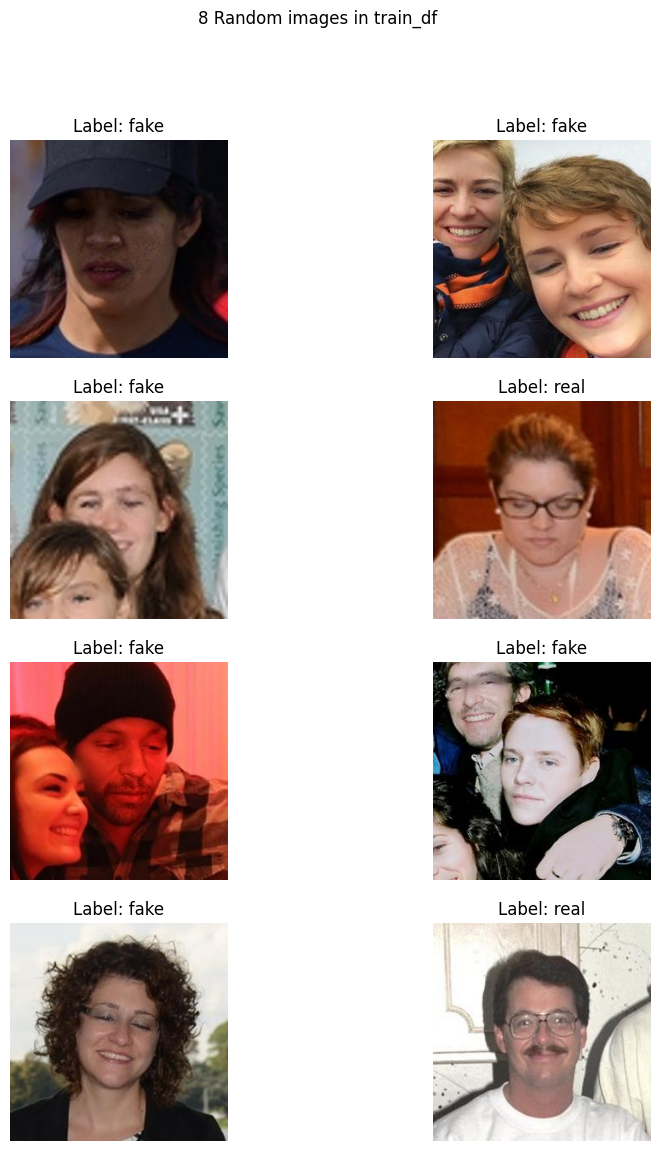

In [78]:
# Display the images
i = 0 # Iter index

# Create a figure with a specified size
plt.figure(figsize=(10, 13))

# Loop throw all the rows
for i in range(len(train_random_rows)):
  # Get the row
  row = train_random_rows.iloc[i]

  plt.subplot(n_rows//2, 2, i + 1)
  plt.imshow(plt.imread(row.loc["path"]))
  plt.title(f"Label: %s"%(row["face_type"]))
  plt.axis('off')

  i += 1

plt.suptitle("%i Random images in train_df"%(n_rows))
plt.show()

In [80]:
train_df.head()

,face_type,path
0,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
1,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
2,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
3,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...
4,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...


In [96]:
# Add a column that contains the images
train_image_paths_list = list(train_df["path"].values)

# Map all the paths into images using cv2.imread
train_images = list(np.stack(list(map(cv2.imread, train_image_paths_list))))

train_df["image"] = train_images
train_df.head()

,face_type,path,image
0,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[4, 50, 38], [7, 53, 41], [16, 60, 47], [23,..."
1,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[184, 184, 184], [184, 184, 184], [184, 184,..."
2,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[33, 45, 51], [27, 39, 45], [18, 30, 34], [1..."
3,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[216, 208, 208], [212, 204, 204], [208, 198,..."
4,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[237, 206, 197], [238, 206, 193], [254, 217,..."


In [133]:
# Add a column that contains the images
test_image_paths_list = list(test_df["path"].values)

# Map all the paths into images using cv2.imread
test_images = list(np.stack(list(map(cv2.imread, test_image_paths_list))))

test_df["image"] = test_images
test_df.head()

,face_type,path,image
0,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[108, 112, 117], [109, 113, 118], [110, 114,..."
1,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[107, 112, 111], [109, 114, 113], [112, 117,..."
2,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[232, 199, 233], [239, 206, 240], [247, 208,..."
3,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[181, 174, 195], [179, 149, 184], [125, 50, ..."
4,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[45, 63, 70], [30, 48, 55], [30, 43, 51], [3..."


In [107]:
img_shape = train_df.iloc[0]["image"].shape
print("Shape of image:", img_shape)

Shape of image: (256, 256, 3)


## Computer Vision

In [141]:
# First we should one-hot encode the labels
train_labels = train_df["face_type"].values # Get the labels
test_labels = test_df["face_type"].values # Get the labels

# Initialize LabelEncoder
encoder = LabelEncoder()

# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.fit_transform(test_labels)

# Add to the data frames
train_df["face_type_onehot"] = train_labels_encoded
test_df["face_type_onehot"] = test_labels_encoded

In [142]:
train_df.head()

,face_type,path,image,face_type_onehot
0,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[4, 50, 38], [7, 53, 41], [16, 60, 47], [23,...",1
1,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[184, 184, 184], [184, 184, 184], [184, 184,...",1
2,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[33, 45, 51], [27, 39, 45], [18, 30, 34], [1...",1
3,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[216, 208, 208], [212, 204, 204], [208, 198,...",1
4,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[237, 206, 197], [238, 206, 193], [254, 217,...",1


In [143]:
test_df.head()

,face_type,path,image,face_type_onehot
0,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[108, 112, 117], [109, 113, 118], [110, 114,...",1
1,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[107, 112, 111], [109, 114, 113], [112, 117,...",1
2,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[232, 199, 233], [239, 206, 240], [247, 208,...",1
3,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[181, 174, 195], [179, 149, 184], [125, 50, ...",1
4,real,/content/drive/MyDrive/Fake-Detector/Dataset/T...,"[[[45, 63, 70], [30, 48, 55], [30, 43, 51], [3...",1


In [113]:
# Input layer is the inital shape of the image that in input into the CNN
input_layer = tf.keras.Input(shape=img_shape, name='input_image')

In [116]:
def initialize_model(input_layer):
    """Returns a compiled model.

    Parameters:
        input_layer: A tf.keras.layers.InputLayer() specifying the shape of the input.
            RGB colored images, shape: (width, height, 3)
    Returns:
        model: A compiled model
    """

    # Instantiate the Sequential model
    model = Sequential()

    # Data augmentation for better training
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomZoom(0.1))
    model.add(layers.RandomTranslation(0.2, 0.2))
    model.add(layers.RandomRotation(0.1))

    # Input layer
    # Image shape
    shape = input_layer.shape[1:]

    # Transfer learning due to overfitting
    vgg16 = VGG16(weights = "imagenet", # imagenet dataset
              include_top = False, # Exclude Hidden Dense Layers + Predictive Dense Layer
              input_shape = shape) # Specify shape as this is the input layer

    # Set the vgg16 weights to none trainable
    vgg16.trainable = False

    # Add the VGG16 base model
    model.add(vgg16)

    # Convolutional layers
    # Conv2D is a convolutional layer that extracts important features of the image
    model.add(layers.Conv2D(filters=128, # Start with a large number of kernels so the network can learn a lot
                            kernel_size=(3,3),
                            activation="relu", # Activate positive numbers
                            padding = "same")) # Padding adds zeros to the edges to emphasize edge importance
    model.add(layers.MaxPooling2D(pool_size=(2,2), # Maxpooling select the maximum value in order to downsample
                                  padding = "same"))

    # Convolutional layer 2
    model.add(layers.Conv2D(filters=64,
                            kernel_size=(3,3),
                            activation="relu",
                            padding = "same"))
    model.add(layers.MaxPooling2D(pool_size=(2,2),
                                  padding = "same"))
    # Convolutional layer 3
    model.add(layers.Conv2D(filters=32,
                            kernel_size=(3,3),
                            activation="relu",
                            padding = "same"))
    model.add(layers.MaxPooling2D(pool_size=(2,2),
                                  padding = "same"))
    # # Convolutional layer 4
    # model.add(layers.Conv2D(filters=16,
    #                         kernel_size=(3,3),
    #                         activation="relu",
    #                         padding = "same"))
    # model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same"))

    # Flatten the downsampled image so it can be fed into a dense layer
    model.add(layers.Flatten())

    # Hidden Dense Layers
    model.add(layers.Dense(64, activation = "relu"))

    # # Dropout 50 % of the neurons during training to force neurons to learn more generally
    # model.add(layers.Dropout(rate=0.5))

    # Predictive layer
    # 2 classes of faces
    # softmax for multiclass problems
    pred_layer = model.add(layers.Dense(2, activation = "sigmoid"))

    initial_learning_rate = 0.001 # Default Adam value

    adam = optimizers.Adam(learning_rate = initial_learning_rate)

    loss = losses.SparseCategoricalCrossentropy(from_logits = False)

    model.compile(optimizer = adam,
                  loss = loss,
                  metrics = ["accuracy"])

    # Return the compiled model
    return model

In [117]:
ml_model = initialize_model(input_layer)

In [119]:
ml_model.build(input_shape=input_layer.shape)  # Build the model with the input shape

In [120]:
print("Model Summary")
print(ml_model.summary())

Model Summary
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_translation_5 (Rand  (None, 256, 256, 3)       0         
 omTranslation)                                                  
                                                                 
 random_rotation_5 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8

In [121]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
# Prevents overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=20,
                                            restore_best_weights=True)

In [150]:
# Convert images to numpy array of arrays
train_images = np.array(train_df["image"].values.tolist())
test_images = np.array(train_df["image"].values.tolist())

# Convert one-hot encoded labels to numpy array of arrays
train_labels_onehot = np.array(train_df["face_type_onehot"].values.tolist())
test_labels_onehot = np.array(test_df["face_type_onehot"].values.tolist())

In [153]:
# The fit
# Use the test data for evaluation of train data
history = ml_model.fit(train_images, train_labels_onehot,
                        batch_size = batch_size,
                        epochs = n_epochs,
                        callbacks = [callback],
                        validation_data = (test_images, test_labels_onehot))

Epoch 1/10
20/20 [==============================] - 376s 19s/step - loss: 0.5594 - accuracy: 0.7350 - val_loss: 0.3008 - val_accuracy: 0.8950
Epoch 2/10
20/20 [==============================] - 371s 19s/step - loss: 0.5947 - accuracy: 0.6900 - val_loss: 0.2867 - val_accuracy: 0.8650
Epoch 3/10
20/20 [==============================] - 373s 19s/step - loss: 0.3630 - accuracy: 0.8100 - val_loss: 0.3287 - val_accuracy: 0.8450
Epoch 4/10
20/20 [==============================] - 376s 19s/step - loss: 0.3379 - accuracy: 0.8400 - val_loss: 0.2200 - val_accuracy: 0.8900
Epoch 5/10
20/20 [==============================] - 372s 19s/step - loss: 0.3304 - accuracy: 0.8450 - val_loss: 0.1612 - val_accuracy: 0.9550
Epoch 6/10
20/20 [==============================] - 337s 17s/step - loss: 0.3235 - accuracy: 0.8350 - val_loss: 0.1272 - val_accuracy: 0.9550
Epoch 7/10
20/20 [==============================] - 373s 19s/step - loss: 0.3879 - accuracy: 0.8300 - val_loss: 0.1708 - val_accuracy: 0.9350
Epoch 

In [154]:
def learning_curves(history):
    """
    Function to calculate and output the learning curve graphs.

    Parameters:
        history: machine learning model.fit instance
    """
    # Plot the learning curves
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.savefig("/content/drive/MyDrive/Fake-Detector/Images/learning_curves_validation_accuracy.png")

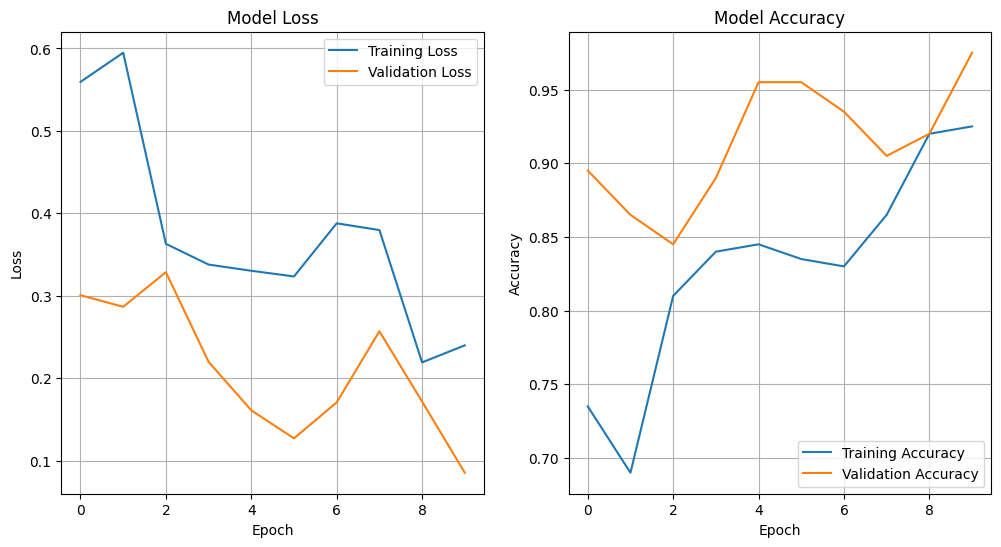

In [155]:
# Plot the learning curves
learning_curves(history)

In [159]:
# Filename to save the model
path = "/content/drive/MyDrive/Fake-Detector/models/"
filename = "ml_model.pkl"

# Save the model to disk
with open(path+filename, 'wb') as file:
    pickle.dump(ml_model, file)